# Project 1: Linear Regression

a) Plain old linear regression, with no regularization. You must code this one by hand (i.e use equation 3.6 to find the betas).  Report the mean squared error on the test dataset. Replicate tables 3.1 and 3.2. You will not need the validation set for this part of the assignment.



b) Ridge regression. You must also code this one by hand(eq 3.44 to find the betas). Select the optimal value of Lambda by cross-validation using the validation dataset. Report the mean squared error on the test dataset, using the best lambda you found on the validation set. DO NOT USE THE TEST DATASET TO CHOOSE LAMBDA. Plot a ridge plot similar to figure 3.8, but you can just sweep the lambda parameter (you don't have to scale it to degrees of freedom).



c) Lasso regression: Use  the built in packages in sci-kit learn or MATLAB to do a Lasso regression. Select the optimal value of lambda as in part b) and also display a Lasso plot similar to figure 3.10, but again you can just sweep the lambda parameter. 



Next, download a dataset suitable for linear regression from UCI or another repository. For now, this should be a dataset that only has numerical features, with no missing values. Repeat the analysis above on this dataset.

In [501]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
from scipy import stats
from sklearn.linear_model import Lasso


In [511]:
prostate_df = pd.read_csv('prostate.txt', delimiter='\t', index_col=0)
df_train = prostate_df.pop('train')
df_y = prostate_df.pop('lpsa')

In [512]:
train_df = prostate_df.loc[df_train == 'T']
val_df  = prostate_df.loc[df_train == 'F'][:15]
test_df  = prostate_df.loc[df_train == 'F'][15:]

print(len(train_df), len(val_df), len(test_df))

67 15 15


In [523]:
# normalize data
df_means = np.mean(prostate_df, axis=0)
df_std = np.std(prostate_df, axis=0)
prostate_df = (prostate_df - df_means) / df_std

In [524]:
X_train = prostate_df.loc[df_train == 'T'] # shape: (67,8) -> (N, p)
y_train = df_y[df_train == 'T'] # shape: (67,)

X_val = prostate_df.loc[df_train == 'F'][:15] 
y_val = df_y[df_train == 'F'][:15]

X_test = prostate_df.loc[df_train == 'F'][15:] 
y_test = df_y[df_train == 'F'][15:] 

# 1. Linear Regression

## Estimate Betas

In [505]:
X_train_b = np.hstack((np.ones((X_train.shape[0], 1)), X_train))    # add bias terms (ones) to first col -> (N, p+1)
X_test_b = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

beta = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train # shape: (9,), estimated coefficients

y_pred = np.dot(X_test_b, beta) # estimate for tests
mse = np.mean((y_test - y_pred)**2) # compute MSE

print("MSE on test set:", mse)

MSE on test set: 0.7776408048062767


## Plot Feature Correlation + Z-Score

In [506]:
X_train.corr()  # does it have to be a lower triangle shape?


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000


In [507]:
# get residuals
y_pred_train = X_train_b @ beta # estimate for trains
residuals = y_train - y_pred_train

# estimate var
var = np.sum((y_pred_train - y_train)**2) / (X_train_b.shape[0] - X_train_b.shape[1])

# std error
standard_errors = np.sqrt(np.diag(var * np.linalg.inv(X_train_b.T @ X_train_b)))    # sqrt term in z-score

# z-scores
z_scores = np.round(beta / standard_errors,2)

In [508]:
terms = ['Intercept'] + [i for i in X_train.columns]

pd.DataFrame({'Coefficient': beta, 'Std. Error': standard_errors,'Z Score' : z_scores}, index = terms)


,Coefficient,Std. Error,Z Score
Intercept,2.464933,0.089315,27.60
lcavol,0.676016,0.125975,5.37
lweight,0.261694,0.095134,2.75
age,-0.140734,0.100819,-1.40
lbph,0.209061,0.101691,2.06
svi,0.303623,0.122962,2.47
lcp,-0.287002,0.153731,-1.87
gleason,-0.021195,0.144497,-0.15
pgg45,0.265576,0.152820,1.74


# 2. Ridge Regression

In [533]:
# center data

train_means = np.mean(X_train, axis=0)
X_train = X_train - train_means
X_val = X_val - train_means
X_test = X_test - train_means

In [558]:
def get_ridge_betas(lam, X, y):
    return np.linalg.inv((X.T @ X) + (lam * np.eye(X.shape[1]))) @ X.T @ y

def get_df(lam, X):
    return np.trace(np.dot(X, np.linalg.inv(X.T @ X + lam * np.eye(X.shape[1]))) @ X.T)


In [578]:
lams = np.logspace(-2,10,100)
best_lam = 0
best_mse = 100000  # random high mse
betas = []
dfs = []
best_beta = []

for l in lams:
    beta_ridge = get_ridge_betas(l, X_train, y_train)
    y_val_pred = np.dot(X_val, beta_ridge) # estimate for val
    mse = np.mean((y_val - y_val_pred)**2) # compute MSE
    betas.append(beta_ridge)
    dfs.append(get_df(l, X_train))
    # print(get_df(l, X_train))
    if mse < best_mse:
        best_mse = mse
        best_lam = l
        best_beta = beta_ridge

betas = np.array(betas)
dfs = np.array(dfs)
    
print(f"Best lambda: {best_lam}, Val MSE: {best_mse}")
best_beta_reg = best_beta

Best lambda: 10000000000.0, Val MSE: 3.57690500253395


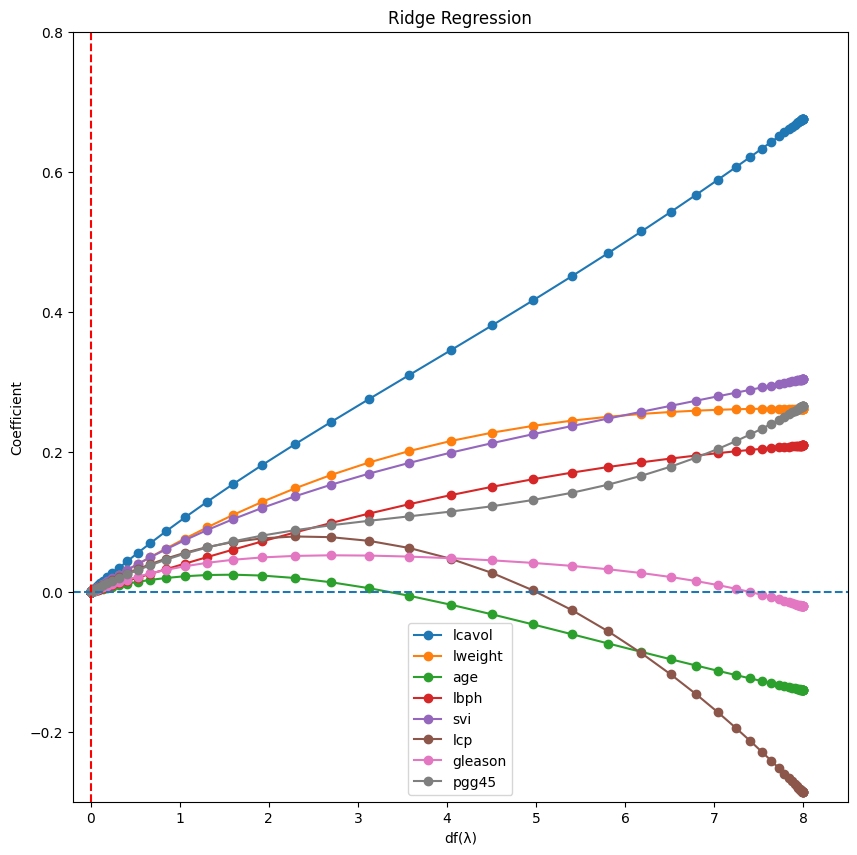

In [579]:
# Plotting coefficients as a function of lambda
plt.figure(figsize=(10,10))
for i in range(betas.shape[1]):
    plt.plot(dfs, betas[:, i], label=f"{X_train.columns[i]}",marker='o')
    # plt.plot(lams, betas[:,i], label=f"{X_train.columns[i]}")

plt.xlabel('df(λ)')
plt.ylabel('Coefficient')
plt.title('Ridge Regression')
plt.xlim([-0.2,8.5])
plt.ylim([-0.3,0.8])
plt.axhline(y=0, linestyle='--')
plt.axvline(x=get_df(best_lam, X_train), linestyle='--', color='r')
plt.legend()
plt.show()

In [586]:
# trying out kfold cross val like in textbook bc I don't trust the last plot >:(

from sklearn.model_selection import KFold

lams = np.logspace(-2,10,100)
best_lam = 0
best_mse = 100000  # random high mse
betas = []
dfs = []
best_beta = []
k = 10

kf = KFold(n_splits=k, shuffle=True, random_state=42) 


for l in lams:
    mse_folds = []  

    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = np.array(X_train)[train_idx], np.array(X_train)[val_idx]
        y_train_fold, y_val_fold = np.array(y_train)[train_idx], np.array(y_train)[val_idx]
        
        beta_ridge = get_ridge_betas(l, X_train_fold, y_train_fold)
        y_val_pred_fold = np.dot(X_val_fold, beta_ridge)
        
        mse_fold = np.mean((y_val_fold - y_val_pred_fold) ** 2)
        mse_folds.append(mse_fold)
    
    # avg MSE over all folds
    avg_mse = np.mean(mse_folds)
    
    betas.append(beta_ridge)
    dfs.append(get_df(l, X_train))
    
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_lam = l
        best_beta = beta_ridge

betas = np.array(betas)
dfs = np.array(dfs)

print(f"Best lambda: {best_lam}, Val MSE: {best_mse}")
best_beta_fold = best_beta

Best lambda: 174.7528400007683, Val MSE: 7.050866058574849


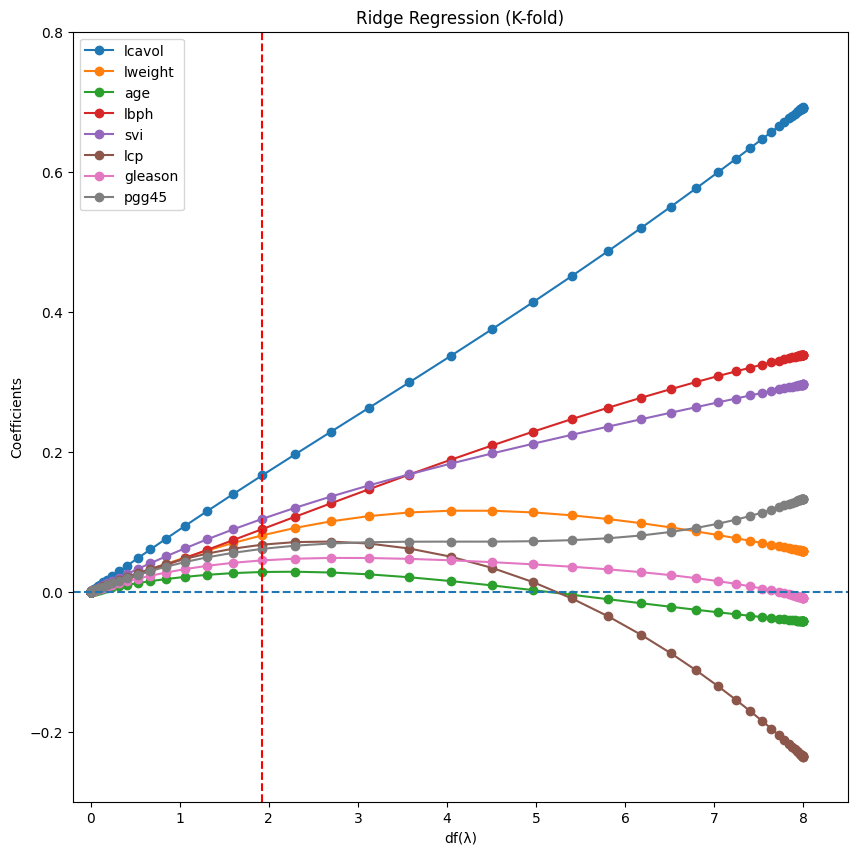

In [587]:
# Plotting coefficients as a function of lambda
plt.figure(figsize=(10,10))
for i in range(betas.shape[1]):
    plt.plot(dfs, betas[:, i], label=f"{X_train.columns[i]}",marker='o')
    # plt.plot(lams, betas[:,i], label=f"{X_train.columns[i]}")

plt.xlabel('df(λ)')
plt.ylabel('Coefficients')
plt.title('Ridge Regression (K-fold)')
plt.xlim([-0.2,8.5])
plt.ylim([-0.3,0.8])
plt.axhline(y=0, linestyle='--')
plt.axvline(x=get_df(best_lam, X_train), linestyle='--', color='r')
plt.legend()
plt.show()

In [621]:
# X_test_centered = (X_test - X_train_mean) / X_train_std  # Use the same mean and std from training data

y_test_pred = np.dot(X_test, best_beta_reg) # estimate for val
mse = np.mean((y_test - y_test_pred)**2) # compute MSE
print('Test MSE: ', mse) # lmao :(

y_test_pred = np.dot(X_test, best_beta_fold) # estimate for val
mse = np.mean((y_test - y_test_pred)**2) # compute MSE
print('Test MSE (KFold): ', mse) # lmao :(

Test MSE:  11.390521717906568


ValueError: operands could not be broadcast together with shapes (15,) (15,8) 

# 3. Lasso Regression

In [618]:
# lams = np.logspace(-2,10,100)
lams = np.linspace(0,1,1000)
best_lam = 0
best_mse = 100000  # random high mse
betas = []
dfs = []
best_beta = []

for l in lams:
    lasso = Lasso(alpha=l)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_val)
    mse = np.mean((y_val - y_pred)**2)
    # dfs.append(get_df(l, X_train))
    betas.append(lasso.coef_)
    # print(get_df(l, X_train))
    if mse < best_mse:
        best_mse = mse
        best_lam = l
        best_beta = beta_ridge

betas = np.array(betas)
dfs = np.array(dfs)
    
print(f"Best lambda: {best_lam}, Val MSE: {best_mse}")
best_beta_reg = best_beta

/home/lizocf/.local/lib/python3.10/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/lizocf/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/lizocf/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.471e+01, tolerance: 9.628e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_f

Best lambda: 0.0, Val MSE: 0.25913041389167396


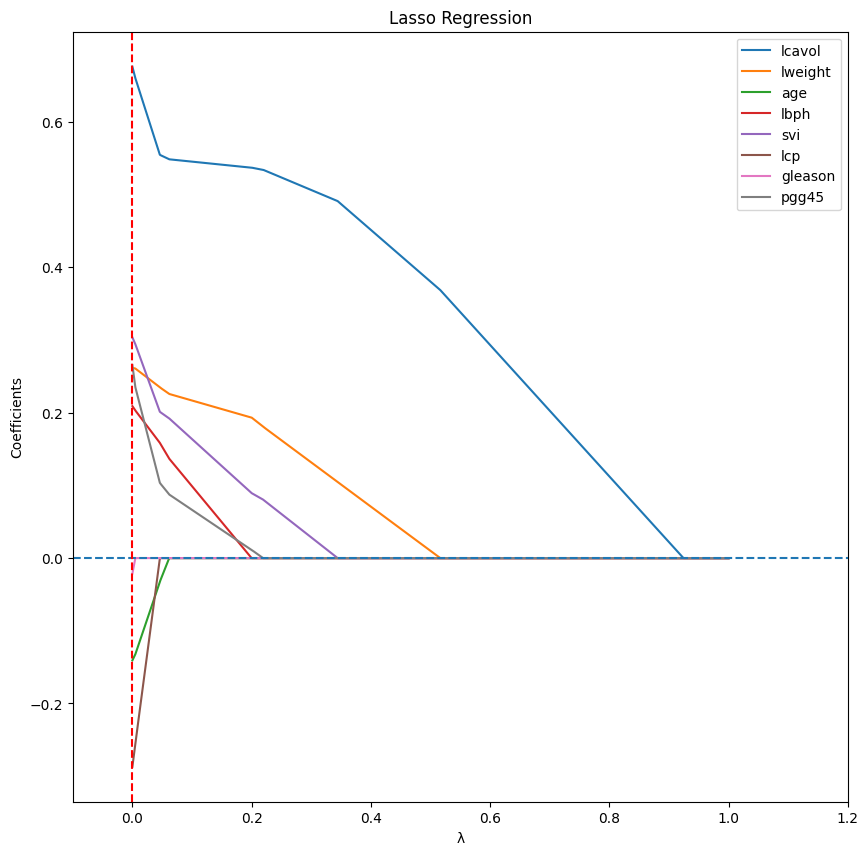

In [619]:
# Plotting coefficients as a function of lambda
plt.figure(figsize=(10,10))
for i in range(betas.shape[1]):
    # plt.plot(dfs, betas[:, i], label=f"{X_train.columns[i]}",marker='o')
    plt.plot(lams, betas[:,i], label=f"{X_train.columns[i]}")

plt.xlabel('λ')
plt.ylabel('Coefficients')
plt.title('Lasso Regression')
plt.xlim([-0.1,1.2])
# plt.ylim([-0.3,0.8])
plt.axhline(y=0, linestyle='--')
plt.axvline(x=best_lam, linestyle='--', color='r')
plt.legend()
plt.show()

In [620]:
y_pred = lasso.predict(X_test)
mse = np.mean((y_test - y_pred)**2)
print('Test MSE: ', mse) # lmao :(

Test MSE:  1.4130735194075703
